# Searching for Rare CellTypes

In this notebook we provide the code to search for the nearest neighbors of any cell of interest using the perisomatic feature space. Examples of this type of unsupervised search are highlighted in the two tutorial notebooks titled Searching for Rare Celltypes and illustrated in our analyses in Figure 6 of our accompanying manuscript.  

In [1]:
import pandas as pd
import numpy as np 
import pcg_skel
import matplotlib.pyplot as plt
import seaborn as sns
from meshparty import meshwork
import caveclient
import numpy as np
from meshparty import trimesh_io
from nglui.statebuilder import *
import skeleton_plot
%matplotlib inline

/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)


To start out, let's take a look at all the predicted inhibitory neurons in the dataset in the 2D UMAP embedding space. Note that this embedding only shows inhibitory neurons as it includes 120 Post-Synaptic Shape (PSS) features.

The following plot shows all the predicted inhibitory neurons in gray with the manually labeled cortical column cells in color (Fig. 4).

In [4]:
df = pd.read_pickle('../../data/inhibitory_perisomatic_feats_v661.pkl')
#df = df.reset_index(drop = True)

If you are interested in searching for a non-inhibitory cell type, uncomment the line of code to use microns_SomaData_AllCells_v661.pkl instead. Note that it has all the cells in the published dataset (Excitatory, inhibitory, and nonneurons).

In [8]:
df = pd.read_pickle('../../data/microns_SomaData_AllCells_v661.pkl')

In [6]:
#Custom color palette
color_dict = {'23P':'#8268DC',
              '4P':'#647FDC',
              '5P-IT':'#77BCDE',
              '5P-ET':'#87DD90',
              '5P-NP':'#85DEC9',
              '6P-CT':'#96DD70',
              '6P-IT':'#DCC86E',
              'BC':'#D68C66',
              'BPC':'#D3697C',
              'MC':'#D36BBA',
              'NGC':'#BC6BDB',
              'astrocyte':'#009245',
              'pericyte':'#754C24',
              'microglia':'#006837',
              'oligo':'#8CC63F',
              'OPC':'#998675',
              'error':'#899499'
    
}

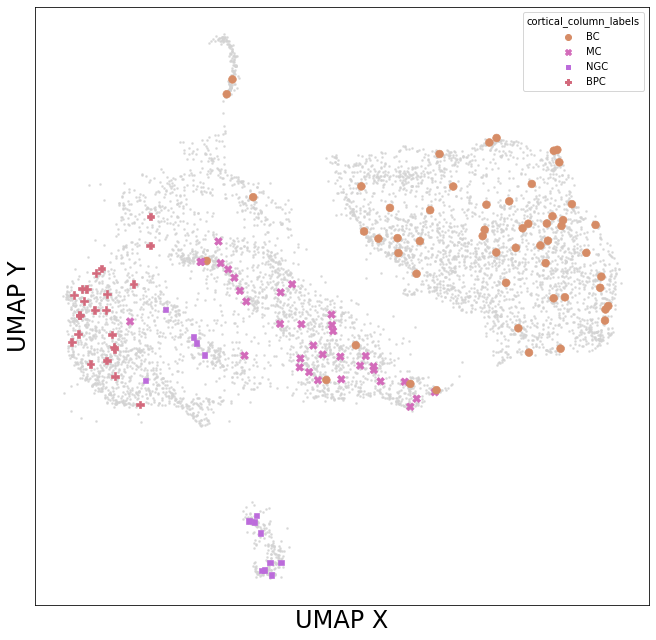

In [7]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', color='lightgray',
                ax =ax, s=5, alpha=0.9, edgecolor=None, data=df, legend = True)

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, s=60, alpha=1, hue='cortical_column_labels',style='cortical_column_labels',
                palette=color_dict, legend = True,
                c=(.2,.2,.2),edgecolor=None, data=df)

ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

If you are using the entire dataset, you can visualize the 2D embedding of all the cells with the code below.

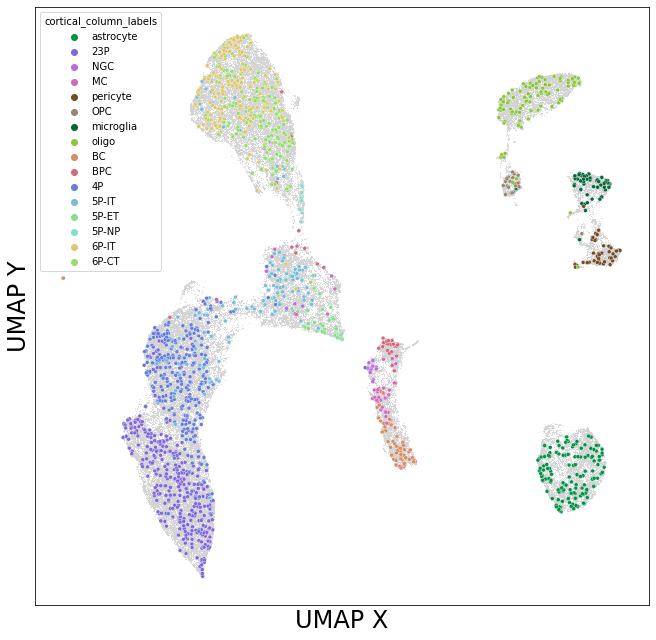

In [12]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='umap_embedding_x', y='umap_embedding_y', color='lightgray',
                ax =ax, s=1, alpha=0.9, edgecolor=None, data=df, legend = True)

sns.scatterplot( x='umap_embedding_x', y='umap_embedding_y', 
                ax =ax, s=15, alpha=1, hue='cortical_column_labels',
                palette=color_dict, legend = True,
                c=(.2,.2,.2),edgecolor='white', data=df)

ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Cells of Interest

To search for cells you must have either a cell ID (pt_root_id) or a nucleus ID. The most robust ID is the nucleus ID as it does not change between different versions of the dataset. 

In [ ]:
#Setting up our client to access the data
client = caveclient.CAVEclient('minnie65_phase3_v1')

#client.materialize.get_tables()
# #Our nucleus table with all cells with a soma within the dataset
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, 
                                       desired_resolution=(1000,1000,1000))

If you have cell IDs

In [22]:
df.columns

Index(['soma_id', 'nucleus_id', 'soma_depth_x', 'soma_depth_y', 'soma_depth_z',
       'is_column', 'nucleus_volume_um', 'nucleus_area_um',
       'nuclear_area_to_volume_ratio', 'nuclear_folding_area_um',
       'fraction_nuclear_folding', 'nucleus_to_soma_ratio', 'soma_volume_um',
       'soma_area_um', 'soma_to_nucleus_center_dist',
       'soma_area_to_volume_ratio', 'soma_synapse_number',
       'soma_synapse_density_um', 'cortical_column_labels', 'predicted_class',
       'predicted_subclass', 'umap_embedding_x', 'umap_embedding_y'],
      dtype='object')

In [26]:
cells = [] 

nuc_ids = nuc_df.query('pt_root_id in @cells').id.tolist()
nuc_ids

[]

If you have nucleus IDs

In [27]:
nuclei = [301101, 335537, 335521, 335691] 
nuc_ids = nuc_df.query('id in @nuclei').id.tolist()
nuc_ids

[335521, 335537, 335691, 301101]

It is worth checking that the length of nuc_ids is the same as your cells of interest. If not it is possible that these IDs are out of date (if cell IDs) or that they did not pass the quality control steps outlined in our manuscript. 

Note: This is most relevant to nonneuronal cells and cells near the borders of the dataset since they were more likely to fail our QC protocol.

### Selecting nearest neighbors

Now that you have identified your cell of interest, let's try to find more. To do this we will use a KDTree graph based on the perisomatic features and select the top N nearest neighbors.

In [28]:
from sklearn.neighbors import KDTree
from sklearn import preprocessing

In [30]:
num_neighbors = 20 #number for neighbors to return - change this as needed!

Below is the code to select the relevant features, build the KDTree, and return the nearest neighbors. Be sure to use inhibitory_search() if you cell is an inhibitory neuron and allcell_search() if it is an excitatory or non-neuronal cell.

In [44]:
soma_metrics = [ 'soma_depth_y','nucleus_volume_um', 'nucleus_area_um', 
                'nuclear_area_to_volume_ratio', 'nuclear_folding_area_um', 
                'fraction_nuclear_folding', 'nucleus_to_soma_ratio', 
                'soma_volume_um', 'soma_area_um', 'soma_to_nucleus_center_dist', 
                'soma_area_to_volume_ratio', 'soma_synapse_number', 'soma_synapse_density_um']

def allcell_search(root_cell_id, df,
                   num_neighbors=num_neighbors,
                   ct='All'):
    if ct == 'Inhibitory': # will use the soma and post-synaptic features for inhibitory cells only
        #Load the zscored perisomatic features for all predicted inhibitory cells
        cell_features_normalized = np.load('../../data/inhibitory_normalized_perisomatic_features.npy')
    else: # will use only the soma features for all cells
        df = df.reset_index(drop=True) #reset index to avoid issues with KDTree
        cell_features = df[soma_metrics].to_numpy() #convert to numpy array

        #Normalize soma features
        scaler=preprocessing.StandardScaler().fit(cell_features)
        cell_features_normalized = scaler.transform(cell_features)

    n_features = cell_features_normalized.shape[1]
    
    #KDTree on high dimensional feature space
    kdt = KDTree(cell_features_normalized, leaf_size=30, metric='euclidean')

    #Id of our cell of interest
    idx = df.query('nucleus_id == @root_cell_id').index[0]
    X = cell_features_normalized[idx,:].reshape(1,n_features) #corresponding feature vector for that cell

    n_cells = cell_features_normalized.shape[0]

    #Query for the top 20 nearest neighbors 
    _, all_idxs = kdt.query(X, k=n_cells, return_distance=True)
    similar_idxs = all_idxs[0][:num_neighbors+1] #including the first one, which is the cell itself

    similar_neurons = df.soma_id.iloc[similar_idxs].tolist()
    similar_neuron_nuc_ids = df.nucleus_id.iloc[similar_idxs].tolist()

    return similar_neurons, similar_neuron_nuc_ids

If searching for an inhibitory cell set cell_type='Inhibitory' in the code below

If searching for an excitatory or non-neuronal cell change cell_type='All' in the code below

In [39]:
cell_type = 'All'
similar_dict = {}
for nuc in nuc_ids:
    print("Nucleus ID of interest:", nuc)
    similar_dict[nuc]={}
    similar_cells, similar_nuc_ids = allcell_search(nuc, df,
                                                    num_neighbors=num_neighbors,
                                                    ct=cell_type)
    similar_dict[nuc]['soma_ids'] = similar_cells
    similar_dict[nuc]['nuc_ids'] = similar_nuc_ids
    print("\n")

print(similar_dict)

Nucleus ID of interest: 335521


Nucleus ID of interest: 335537


Nucleus ID of interest: 335691


Nucleus ID of interest: 301101


{335521: {'soma_ids': [864691135341346245, 864691135447352148, 864691135975464303, 864691135684336370, 864691135883895664, 864691135526333787, 864691135778118077, 864691135777618272, 864691135654159810, 864691135724769451, 864691135919383216, 864691135989179392, 864691135345673631, 864691135565543191, 864691135341044677, 864691136896065646, 864691135953299914, 864691136371758728, 864691135683946935, 864691135738480497, 864691135749590313], 'nuc_ids': [335521, 165131, 669656, 430870, 161872, 615467, 492447, 302592, 589645, 195694, 368341, 666128, 124792, 433010, 198288, 458344, 560980, 560244, 588008, 664708, 666514]}, 335537: {'soma_ids': [864691136238600508, 864691135884668016, 864691136911650289, 864691136100927861, 864691135781847888, 864691135865884805, 864691136009450924, 864691135654107842, 864691135274622181, 864691136522768017, 864691135545115688, 

If we plot these nearest neighbors in the 2D UMAP embedding space we can see where in this feature space these cells are coming from. Note that the nearest neighbors were selected from the high dimensional feature space not the 2D embedding.

In [40]:
import math

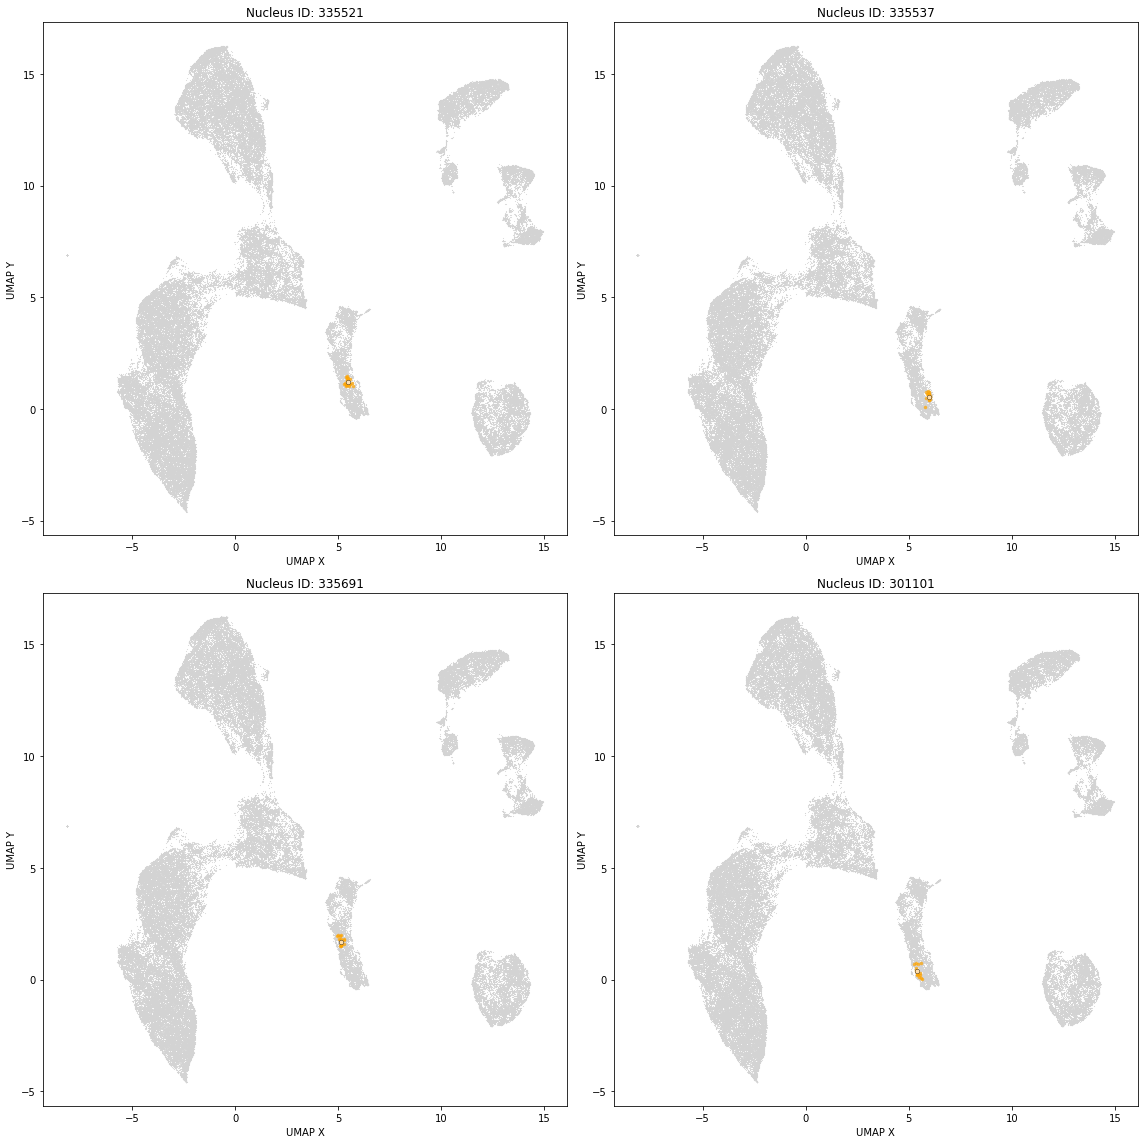

In [43]:
if cell_type == 'Inhibitory':
        title_str = f'Inhibitory cells similar to nuc_id {nuc}'
        x_embed = 'inhib_umap_embedding_x'
        y_embed = 'inhib_umap_embedding_y'
else:
    title_str = f'Cells similar to nuc_id {nuc}'
    x_embed = 'umap_embedding_x'
    y_embed = 'umap_embedding_y'
    
    
num_plots = len(nuc_ids)
cols = 2  # Number of columns in the grid
rows = math.ceil(num_plots / cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows), facecolor='white')
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, nuc in enumerate(nuc_ids):
    ax = axes[i]
    similar_nuc_ids = similar_dict[nuc]['nuc_ids']

    sns.scatterplot(x=x_embed, y=y_embed, color='lightgray',
                    ax=ax, s=1, alpha=0.9, edgecolor=None, data=df, legend=False)

    sns.scatterplot(x=x_embed, y=y_embed,
                    ax=ax, alpha=0.7, color='orange', edgecolor=None,
                    s=10, data=df.query('nucleus_id in @similar_nuc_ids'))
    
    sns.scatterplot(x=x_embed, y=y_embed,
                    ax=ax, alpha=1, color='navajowhite', edgecolor='black',
                    s=20, data=df.query('nucleus_id == @nuc'))

    ax.set_xlabel('UMAP X')
    ax.set_ylabel('UMAP Y')
    ax.set_title(f'Nucleus ID: {nuc}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


    